This notebook calculate and plot biogenic (isoprene) emissions over the IGP

In [1]:
# import modules
%run ../load_main.py
import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/phd_work/')
from Air_Quality_notebooks import utils as utl
from WRFChemToolkit.analysis import statistics as st

WRFchem outputs data path is: dpath=/geos/d21/s1878599/IGP


## Define functions

### plot

In [2]:
#SPATIAL PLOT IGP

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

def set_formatter(axes):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
        gl.ylabels_left = False
        gl.ylocator = mticker.FixedLocator([20,25,30,35])
        gl.xlocator = mticker.FixedLocator([70,80,90])
        
        ax.add_feature(cfeature.COASTLINE, lw=0.3)
        ax.add_feature(cfeature.BORDERS, lw=0.3)
        
        gl.yformatter = LATITUDE_FORMATTER
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'grey'}
        gl.ylabel_style = {'size': 10, 'color': 'grey'} 
    
    # get lon values only n the last ax
        if ax==axes[3]:
            gl.xlabels_bottom = True
    
    
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=0.9, lw=0.3)
            


def emiplot(lat,lon,pmds,mds,ads,wds, panels=["(c)","(f)","(i)","(l)"], title=None, label=None, cmap="OrRd",vmax=None, vmin=0,levs=10,delta=None,
            figsize=[7, 10],format="%.2f",save=False,spath=None,name="plot",savef='pdf', dpi=100):

    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    igp_shp="/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp"
    shp_path=(igp_shp,igp_shp,igp_shp,igp_shp)
    
    set_formatter(axes.flatten())
    set_admin(axes.flatten(), shp_path)
 
    #Getting values.
    
    vpm=pmds[:,:].values
    vm= mds[:,:].values
    va= ads[:,:].values 
    vw= wds[:,:].values
   
    import math                # Get the max value in the array to plot.
    vmax_v =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max()        
    vmin=vmin
    print(vmax,vmin)
    
    if vmax is None:
        levels = np.linspace(vmin, vmax_v,levs)  # number of levels for which divide the bar. Customised. 
    else:
        levels = np.linspace(vmin, vmax, levs)
    # premonsoon
    cspm=axes[0].contourf(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels, extend="both")
    cspm.cmap.set_under('#FFFFFF')#U IGP values.
    cspm.cmap.set_over('#FFFF00')
                                                 
    # monsoon
    csm=axes[1].contourf(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels, extend="both")
    csm.cmap.set_under('#FFFFFF')#U IGP values.
    csm.cmap.set_over('#FFFF00')
    #autumn
    csa=axes[2].contourf(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels, extend="both")
    csa.cmap.set_under('#FFFFFF')#U IGP values.
    csa.cmap.set_over('#FFFF00')
    #winter
    csw=axes[3].contourf(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels, extend="both")
    csw.cmap.set_under('#FFFFFF')#U IGP values.
    csw.cmap.set_over('#FFFF00')
    
    """
    axes[0].text(-0.2, 0.55, 'PRE-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[0].transAxes)
    axes[1].text(-0.2, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[1].transAxes)
    axes[2].text(-0.2, 0.55, 'POST-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[2].transAxes)
    axes[3].text(-0.2, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[3].transAxes)
    """
    
    #add panel boxes
    panels=panels
    for ax,p in zip(fig.axes,panels):
        ax.annotate(p, xy=(1, 1), xytext=(-5, -5), fontsize=12,
        xycoords='axes fraction', textcoords='offset points',
        bbox=dict(facecolor='white',edgecolor='white', alpha=0.8),
        horizontalalignment='right', verticalalignment='top')
    
    #cbar
    cbar_ax = fig.add_axes([0.8, 0.15, 0.04, 0.7])  #[left, bottom, width, height]
    cbar= fig.colorbar(csw, cax=cbar_ax,pad=0.1,shrink=0.5, format=format)
    cbar.set_label(label,fontsize=13)
    cbar.ax.tick_params(labelsize='medium')

    #reshape spacing between ticks
    if delta is None:
        delta=0.002
        cbar.set_ticks(list(np.arange(vmin, vmax+delta, delta)))
        #cbar.set_ticklabels([0.001,0.003,0.005,0.007,0.009,0.011,0.013,0.015,0.017])
    
    #title
    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    #save
    if save:
        plt.savefig( spath + name +'.' + savef, format=savef, dpi=dpi,bbox_inches = "tight")
    
    
    fig.show()

### Emissions

biogenic emissions are calculated online. Need to consdier them as an output of the simulation.

In [3]:
def calc_hour_emibio(ds):
    """
    Convert isopr emissions rates back to emissions.
    """
    km2m2=1e+6 # km2 to m2.
    mw_isp = 68  # molar weight of isoprene

    ds["tot_emi_BISOP"]=ds["MEBIO_ISOP"]*mw_isp/km2m2
    ds["tot_emi_BISOP"].attrs["units"]="g m-2 hour-1"
    ds["avg_day_emibio"]=ds.tot_emi_BISOP.sum("Time")/(len(ds.Time)/8)  #divide by number of day, taking into account output every 3 h.
    ds.avg_day_emibio.attrs["units"]="g m-2 day-1"

## Calcualte and plot emissions

In [4]:
# load data
post_pth=dpath+'/outputs/autumn/wrfout*.nc'
win_pth=dpath+'/outputs/winter/wrfout*.nc'
mon_pth=dpath+'/outputs/monsoon/wrfout*.nc'
pre_pth=dpath+'/outputs/premonsoon/wrfout*.nc'

pth_d={"pre":pre_pth,"mon":mon_pth,"post":post_pth,"win":win_pth}

s=utl.dictdata(pth_d) 

In [5]:
#calc emibio
for k in s.keys(): 
    calc_hour_emibio(s[k])

In [6]:
#subset only over IGP
import salem
shdf= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp")
s_igp={}
for k in s.keys(): 
    s_igp.update({k: s[k].salem.roi(shape=shdf)})

0.007 0.001


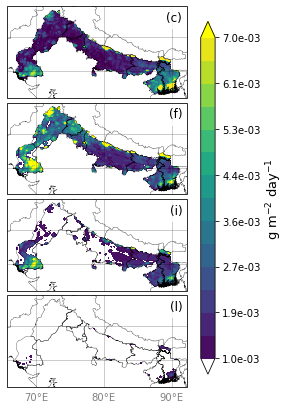

In [7]:
#Plot
lat = s["pre"].XLAT[0,:,:]
lon  = s["pre"].XLONG[0,:, :]

savepth="./"
emiplot(lat,lon,s_igp["pre"].avg_day_emibio,s_igp["mon"].avg_day_emibio,s_igp["post"].avg_day_emibio,s_igp["win"].avg_day_emibio,cmap="viridis", vmin=0.001,vmax=0.007,label="g m$^{-2}$ day$^{-1}$", 
        levs=15,delta=1e-3,figsize=[5,7],format="%.1e",save=True, spath=savepth,name="emi_bio",savef='png', dpi=300)